In [1]:
import pandas as pd

df1 = pd.read_csv('capstone_data_new.csv')

In [271]:
df1.head()

,Unnamed: 0,text,label,length
0,0,Says the Annies List political group supports ...,Fake,82
1,1,"Hillary Clinton agrees with John McCain ""by vo...",Real,105
2,2,Health care reform legislation is likely to ma...,Fake,78
3,3,The Chicago Bears have had more starting quart...,Real,155
4,4,Says GOP primary opponents Glenn Grothman and ...,Real,132


In [272]:
df1.shape

(98532, 4)

### Segregating into short and long texts

In [273]:
df1[df1.length<280]['label'].value_counts()

Fake    27747
Real     4938
Name: label, dtype: int64

In [274]:
df1[df1.length>280]['label'].value_counts()

Real    33292
Fake    32550
Name: label, dtype: int64

In [275]:
df_short = df1[df1.length<280][['text', "label"]]
df_long = df1[df1.length>280][['text', "label"]]

### Working with short texts

In [276]:
df_short.isnull().sum()

text     60
label     0
dtype: int64

In [277]:
df_short.dropna(inplace=True)

In [278]:
df_short.shape

(32625, 2)

We need to represent data as numeric values for the model. We need to do something similar for the textual information from the *text* column, but as this is dependent of the model architecture, this is done in the subsequent notebook.

#### Real is 1 while Fake is 0.

In [279]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
df_short['label'] = enc.fit_transform(df_short['label'])

In [280]:
df_short.head()

,text,label
0,Says the Annies List political group supports ...,0
1,"Hillary Clinton agrees with John McCain ""by vo...",1
2,Health care reform legislation is likely to ma...,0
3,The Chicago Bears have had more starting quart...,1
4,Says GOP primary opponents Glenn Grothman and ...,1


In [281]:
df_short.iloc[4]['text']

'Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.'

In [282]:
df_short.text.sample(10, random_state=1).to_list()

['Actually, @realDonaldTrump, he blocked a potentially unconstitutional executive order. This is how the judicial system work. Not by ranting.',
 "See sense America and don't vote for that criminal Hillary Clinton #Election2016 #HillaryForPrison2016 #TrumpForPresident",
 ' ',
 "The first time he ever voted as a Democrat was here in Florida in 2008. He only voted four times in his life, and he's asking Floridians to come out and vote for him.",
 "'@AJEnglish That's awful!'",
 'Can you blame her for losing her cool with Crooked Lying Hillary? Share this with all of your  undecided  friends!https://youtu.be/CCkXOix0g2Y',
 "'@KellyannePolls @TheCoffeeBean should do well as @realDonaldTrump supporters #BoycottStarbucks for CEO endorsing #CrookedHillary #MAGA'",
 'Well, well, well  The Democrats are delusional with their wish for any scandal in the Trump administration Late today, President Trump reaffirmed his total support for Sessions. ',
 'U.S. House opponent Paul Ryan supports cutting f

## Data Cleaning

1. Removed URLs
2. Removed User Mentions
3. Removed all numbers
4. Removed punctuations and extra spaces

In [283]:
import string
import re

df_short['text'] = df_short['text'].apply(lambda x:re.sub(r'http\S+', '', x))
df_short['text'] = df_short['text'].apply(lambda x:re.sub(r'@\S+ ', '', x))
df_short['text'] = df_short['text'].apply(lambda x:''.join(i for i in x if not i.isdigit()))
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
df_short['text'] = df_short['text'].str.translate(table)
df_short['text'] = df_short['text'].str.replace(' +', ' ')
df_short['text'] = df_short['text'].str.lower()
df_short['text'] = df_short['text'].str.strip()

In [284]:
df_short.text.sample(10, random_state=1).to_list()

['actually he blocked a potentially unconstitutional executive order this is how the judicial system work not by ranting',
 'see sense america and don t vote for that criminal hillary clinton election hillaryforprison trumpforpresident',
 '',
 'the first time he ever voted as a democrat was here in florida in he only voted four times in his life and he s asking floridians to come out and vote for him',
 'that s awful',
 'can you blame her for losing her cool with crooked lying hillary share this with all of your undecided friends',
 'should do well as supporters boycottstarbucks for ceo endorsing crookedhillary maga',
 'well well well the democrats are delusional with their wish for any scandal in the trump administration late today president trump reaffirmed his total support for sessions',
 'u s house opponent paul ryan supports cutting funding for veterans by percent',
 'mayor rudy giuliani said he believes is going to win by states b c americans are tired of corr…']

### Doubts
* keep only english tweets? translate the non-eng ones to eng?

In [285]:
#Train test split
from sklearn.model_selection import train_test_split

X = df_short.text
y = df_short.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [286]:
df_short_train = pd.concat([X_train, y_train], axis=1)
df_short_test = pd.concat([X_test, y_test], axis=1)

In [287]:
# df_short_test = df_short[~df_short.index.isin(df_short_train.index)][df_short.label==1]
# df_short_test = pd.concat([df_short_test, df_short[~df_short.index.isin(df_short_train.index)][df_short.label==0].sample(n = df_short_test.shape[0], random_state=1)])

In [288]:
lengths = [len(df_short_train.iloc[i]['text'].split()) for i in range(len(df_short_train))]
print(max(lengths))
print(min(lengths))

55
0


(array([2516., 6155., 8189., 4817., 2730.,  836.,  477.,  241.,  119.,
          20.]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <a list of 10 Patch objects>)

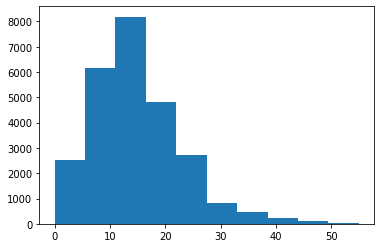

In [289]:
import matplotlib.pyplot as plt

plt.hist(lengths)

In [290]:
import numpy as np
np.median(lengths)

14.0

In [291]:
df_short_train = df_short_train[[l > 0 for l in lengths]]

In [292]:
df_short_train.shape

(25336, 2)

In [293]:
pd.DataFrame(df_short_train['label'].value_counts())

,label
0,21390
1,3946


We then save the preprocessed dataset, and another one corresponding to a 10% sample.

In [294]:
df_short_train.isnull().sum()

text     0
label    0
dtype: int64

In [295]:
df_short_train.to_csv('short_text_preprocessed_train.csv', index=False)
df_short_test.to_csv('short_text_preprocessed_test.csv', index=False)

In [296]:
df_short_train.shape

(25336, 2)

In [297]:
# df_short.sample(n=int(len(df_short)*0.1), random_state=111).to_csv('short_text_sampled.csv', index=False)

## Working with long texts

In [298]:
df_long.head()

,text,label
261,Right now one of our highest job growth sector...,Real
1914,"In 1790, the first Congress, which was packed ...",Real
2722,Let's pay attention to kids who are not going ...,Real
3233,He (Obama) has done several things well. Most ...,Fake
3307,"Under Republican Chris Christie, New Jersey ha...",Real


In [299]:
enc = LabelEncoder()
df_long['label'] = enc.fit_transform(df_long['label'])

In [300]:
df_long.head()

,text,label
261,Right now one of our highest job growth sector...,1
1914,"In 1790, the first Congress, which was packed ...",1
2722,Let's pay attention to kids who are not going ...,1
3233,He (Obama) has done several things well. Most ...,0
3307,"Under Republican Chris Christie, New Jersey ha...",1


In [301]:
df_long.text.sample(1, random_state=1).to_list()

['WASHINGTON  —   “Busy day planned in New York,”   Donald J. Trump said on Twitter on Friday morning, two days after his astonishing victory. “Will soon be making some very important decisions on the people who will be running our government!” If anything, that understates the gravity of the personnel choices Mr. Trump and his transition team are weighing. Rarely in the history of the American presidency has the exercise of choosing people to fill jobs had such a   impact on the nature and priorities of an incoming administration. Unlike most new presidents, Mr. Trump comes into office with no   experience, no coherent political agenda and no bulging binder of policy proposals. And he has left a trail of inflammatory, often contradictory, statements on issues from immigration and race to terrorism and geopolitics. In such a chaotic environment, serving a president who is in many ways a tabula rasa, the appointees to key White House jobs like chief of staff and cabinet posts like secre

In [302]:
df_long['text'] = df_long['text'].apply(lambda x:re.sub(r'http\S+', '', x))
df_long['text'] = df_long['text'].apply(lambda x:re.sub(r'@\S+ ', '', x))
df_long['text'] = df_long['text'].apply(lambda x:''.join(i for i in x if not i.isdigit()))
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
df_long['text'] = df_long['text'].str.translate(table)
df_long['text'] = df_long['text'].str.replace(' +', ' ')
df_long['text'] = df_long['text'].str.lower()
df_long['text'] = df_long['text'].str.strip()

In [303]:
df_long.text.sample(1, random_state=1).to_list()

['washington — “busy day planned in new york ” donald j trump said on twitter on friday morning two days after his astonishing victory “will soon be making some very important decisions on the people who will be running our government ” if anything that understates the gravity of the personnel choices mr trump and his transition team are weighing rarely in the history of the american presidency has the exercise of choosing people to fill jobs had such a impact on the nature and priorities of an incoming administration unlike most new presidents mr trump comes into office with no experience no coherent political agenda and no bulging binder of policy proposals and he has left a trail of inflammatory often contradictory statements on issues from immigration and race to terrorism and geopolitics in such a chaotic environment serving a president who is in many ways a tabula rasa the appointees to key white house jobs like chief of staff and cabinet posts like secretary of state defense sec

In [304]:
#Train test split

X = df_long.text
y = df_long.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

df_long_train = pd.concat([X_train, y_train], axis=1)
df_long_test = pd.concat([X_test, y_test], axis=1)

C:\Users\pmahankal.HIREZCORP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\pmahankal.HIREZCORP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [305]:
lengths = [len(df_long_train.iloc[i]['text'].split()) for i in range(len(df_long_train))]
print(max(lengths))
print(min(lengths))

24092
5


(array([3.3405e+04, 1.3566e+04, 4.2420e+03, 1.0930e+03, 3.4500e+02,
        1.9800e+02, 1.1300e+02, 7.6000e+01, 8.8000e+01, 3.2000e+01]),
 array([   5. ,  502.7, 1000.4, 1498.1, 1995.8, 2493.5, 2991.2, 3488.9,
        3986.6, 4484.3, 4982. ]),
 <a list of 10 Patch objects>)

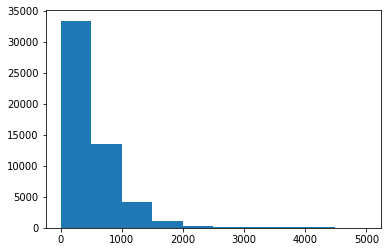

In [306]:
plt.hist([l for l in lengths if l<5000])

In [307]:
np.median(lengths)

407.0

In [308]:
df_long_train.shape

(53268, 2)

In [309]:
df_long_train = df_long_train[[l < 1000 for l in lengths]]

In [310]:
df_long_train.shape

(46962, 2)

In [311]:
df_long_train.label.value_counts()

0    24033
1    22929
Name: label, dtype: int64

In [312]:
df_long_train.to_csv('long_text_preprocessed_train.csv', index=False)
df_long_test.to_csv('long_text_preprocessed_test.csv', index=False)

In [4]:
import pandas as pd

In [5]:
categories = ['ClaimFakeCOVID-19_tweets', 'ClaimRealCOVID-19_tweets', 'NewsFakeCOVID-19_tweets', 'NewsRealCOVID-19_tweets']
filenames = ['politifact_fake', 'politifact_real', 'gossipcop_fake', 'gossipcop_real']

for category, filename in zip(categories, filenames):
    print("Working on category:", category)
    tweet_ids = []
    for i, year in enumerate(['05-01-2020', '07-01-2020', '09-01-2020', '11-01-2020']):
        if category+'.csv' in os.listdir(f'../CoAID/{year}'):
            df = pd.read_csv(f'../CoAID/{year}/{category}.csv')
            tweet_ids.extend(df.tweet_id.to_list())

    final = pd.DataFrame({'id':[category], 'news_url':[''], 'title':[''], 'tweet_ids':'\t'.join(map(str, tweet_ids))})
    print("Saving it to filename: {}.csv".format(filename))
    final.to_csv(f'../CoAID/{filename}.csv', index=False)

Working on category: ClaimFakeCOVID-19_tweets
Saving it to filename: politifact_fake.csv
Working on category: ClaimRealCOVID-19_tweets
Saving it to filename: politifact_real.csv
Working on category: NewsFakeCOVID-19_tweets
Saving it to filename: gossipcop_fake.csv
Working on category: NewsRealCOVID-19_tweets
Saving it to filename: gossipcop_real.csv


In [6]:
import json

PATH = f'..\\FakeNewsNet\\code\\fakenewsnet_dataset\\'

real_tweets = set()
fake_tweets = set()

for status in ['real', 'fake']:
    for category in ['gossipcop', 'politifact']:
        source = os.listdir(PATH+f'{category}\\{status}\\')[0]
        DIR = PATH+f"{category}\\{status}\\{source}\\tweets\\"
        print(DIR)
        print(len(set(os.listdir(DIR))))
        for file in os.listdir(DIR):
            with open(DIR+file) as f:
                text = f.read()
                t = json.loads(text)
                if status=='real':
                    real_tweets.add(t.get('text'))
                else:
                    fake_tweets.add(t.get('text'))
        print("Counts for real and fake tweets:", (len(real_tweets), len(fake_tweets)))

..\FakeNewsNet\code\fakenewsnet_dataset\gossipcop\real\NewsRealCOVID-19_tweets\tweets\
123611
Counts for real and fake tweets: (122714, 0)
..\FakeNewsNet\code\fakenewsnet_dataset\politifact\real\ClaimRealCOVID-19_tweets\tweets\
6683
Counts for real and fake tweets: (129303, 0)
..\FakeNewsNet\code\fakenewsnet_dataset\gossipcop\fake\NewsFakeCOVID-19_tweets\tweets\
7161
Counts for real and fake tweets: (129303, 7118)
..\FakeNewsNet\code\fakenewsnet_dataset\politifact\fake\ClaimFakeCOVID-19_tweets\tweets\
394
Counts for real and fake tweets: (129303, 7512)


In [7]:
df_final = pd.DataFrame({'text':list(real_tweets)+list(fake_tweets), 'label':([1]*len(real_tweets)) + ([0]*len(fake_tweets))})

In [8]:
import string
import re

df_final['text'] = df_final['text'].apply(lambda x:re.sub(r'http\S+', '', x))
df_final['text'] = df_final['text'].apply(lambda x:re.sub(r'@\S+ ', '', x))
df_final['text'] = df_final['text'].apply(lambda x:''.join(i for i in x if not i.isdigit()))
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
df_final['text'] = df_final['text'].str.translate(table)
df_final['text'] = df_final['text'].str.replace(' +', ' ')
df_final['text'] = df_final['text'].str.lower()
df_final['text'] = df_final['text'].str.strip()

In [9]:
df_final.head()

,text,label
0,more vitamin d lower risk of severe covid,1
1,trump to order meat processing plants to remai...,1
2,lockdowns making things worse for obese americ...,1
3,icymi last week several researchers and expert...,1
4,trump signs coronavirus relief package into law,1


In [10]:
df_final.isnull().sum()

text     0
label    0
dtype: int64

In [11]:
df_final.shape

(136815, 2)

In [12]:
import os
p = 'tmp_dir/another_dir/saved_df.csv'
print(os.path.join(*p.split('/')[:2]))
os.makedirs(os.path.join(*p.split('/')[:2]), exist_ok=True)
df_final.to_csv(p, index=False)

tmp_dir\another_dir


In [13]:
df_final.label.value_counts()

1    129303
0      7512
Name: label, dtype: int64

In [14]:
pd.read_csv('data/shorttextpreprocessedtrain.csv').shape

(25336, 2)

In [15]:
df_final_final = df_final.append(pd.read_csv('data/shorttextpreprocessedtrain.csv'))

In [17]:
df_final_final = df_final_final.sample(frac = 1)

In [18]:
df_final_final.to_csv('data/newdatasetwithcoviddata.csv', index=False)

In [19]:
df_final_final = pd.read_csv('data/newdatasetwithcoviddata.csv').dropna()
df_final_final.to_csv('data/newdatasetwithcoviddata.csv', index=False)

In [20]:
pd.read_csv('data/newdatasetwithcoviddata.csv').isnull().sum()

text     0
label    0
dtype: int64

### Trying out multiprocessing

In [21]:
# import pandas as pd
# import multiprocessing as mp
# import time
# import re 
# from nltk.corpus import stopwords
# import string

# t = str.maketrans(dict.fromkeys(string.punctuation))

# def clean_text(text): 
#     # Remove stop words
#     stops = set(stopwords.words("english"))
#     text = " ".join(list(set(text.lower().split()) - stops))
#     # Remove Special Characters
#     text = text.translate(t)
#     # removing the extra spaces
#     text = re.sub(' +',' ', text)
#     return text

# df = pd.read_csv("src/Blob_04_05_2021/request_2667/fileblock_0.csv") # file loading
# print("Columns of the dataset", list(df.columns))
# print("Total records of the dataset", len(df))

# # Before Parallel Processing
# df1 = df.copy()
# t1 = time.time()
# df1['tweet'] = df1['tweet'].apply(clean_text)
# t2 = time.time()
# print("time consuming before Parallel Processing to process the Dataset {0:.2f}s".format(round(t2-t1, 2)))

# # After Parallel Processing
# p = mp.Pool(mp.cpu_count()-1) # Data parallelism Object
# df2 = df.copy()
# t3 = time.time()
# df2['tweet'] = p.map(clean_text, df2['tweet'])
# t4 = time.time()

# print("time consuming after Parallel Processing to process the Dataset {0:.2f}s".format(round(t4-t3, 2)))